In [1]:
import numpy as np
import scipy as sp
import scipy.stats
import itertools
import logging
import matplotlib.pyplot as plt
import pandas as pd
import torch.utils.data as utils
import math
import time
import tqdm

import torch
import torch.optim as optim
import torch.nn.functional as F
from argparse import ArgumentParser
from torch.distributions import MultivariateNormal

import torch.nn as nn
import torch.nn.init as init
import sys

sys.path.append("../new_flows")
from flows import RealNVP, Planar, MAF
from models import NormalizingFlowModel
import random
from torch.autograd import Variable

In [2]:
import random
from torch.autograd import Variable

In [3]:
df = pd.read_hdf("/data/t3home000/spark/LHCOlympics_previous/preprocessed_40part_testdataset.h5")

In [4]:
dt = df.values

In [5]:
dt.shape

(1100000, 121)

In [6]:
idx = dt[:,120]
bkg_idx = np.where(idx==0)[0]
sig_idx = np.where(idx==1)[0]

In [7]:
dt = dt[:,:120]
label = idx

In [8]:
dt.shape

(1100000, 120)

In [9]:
label.shape

(1100000,)

In [10]:
data = np.reshape(dt, (-1,40,3))

In [11]:
data.shape

(1100000, 40, 3)

In [12]:
label

array([0., 0., 0., ..., 0., 0., 0.])

In [13]:
data_bkg = dt[bkg_idx]

data_sig = dt[sig_idx]

data_bkg = data_bkg[:,0:120]

data_sig = data_sig[:,0:120]

data_bkg = np.reshape(data_bkg, (-1,40,3))

data_bkg.shape # (Nevents, Npfcands, Nfeats)

data_sig = np.reshape(data_sig, (-1,40,3))

data_sig.shape

(100000, 40, 3)

In [14]:
from sklearn.model_selection import train_test_split

sig_train, sig_test = train_test_split(data_sig, test_size=0.2)

In [15]:
class SentenceVAE(nn.Module):
    def __init__(self, input_size, hidden_size, latent_size,num_layers=2, bidirectional=False):

        super().__init__()
        self.tensor = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.Tensor
        # max_sequence_length = 40
        # latent_size, lets call it 10 or shit like that
        self.latent_size = latent_size
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.bidirectional = bidirectional


        rnn = nn.GRU
        # elif rnn_type == 'lstm':
        #     rnn = nn.LSTM

        self.encoder_rnn = rnn(input_size, hidden_size, num_layers=num_layers, bidirectional=self.bidirectional,
                               batch_first=True)
        self.decoder_rnn = rnn(input_size, hidden_size, num_layers=num_layers, bidirectional=self.bidirectional,
                               batch_first=True)

        self.hidden_factor = (2 if bidirectional else 1) * num_layers

        self.hidden2mean = nn.Linear(hidden_size * self.hidden_factor, latent_size)
        self.hidden2logv = nn.Linear(hidden_size * self.hidden_factor, latent_size)
        self.latent2hidden = nn.Linear(latent_size, hidden_size * self.hidden_factor)
        self.latent2input = nn.Linear(latent_size, input_size*40)
        self.output2particles = nn.Linear(hidden_size, input_size)

    def forward(self, input_sequence):

        batch_size = input_sequence.size(0)

        # ENCODER


        _, hidden = self.encoder_rnn(input_sequence)

        if self.bidirectional or self.num_layers > 1:
            # flatten hidden state
            hidden = hidden.view(batch_size, self.hidden_size*self.hidden_factor)
        else:
            hidden = hidden.squeeze()

        # REPARAMETERIZATION
        mean = self.hidden2mean(hidden)
        logv = self.hidden2logv(hidden)
        std = torch.exp(0.5 * logv)

        z = torch.randn([batch_size, self.latent_size]).cuda()
        z = z * std + mean
        kld = -0.5 * torch.sum(1 + logv - mean.pow(2) - logv.exp())

        # DECODER
        hidden = self.latent2hidden(z)
        pseudo_input = self.latent2input(z).view(input_sequence.shape)
       
        if self.bidirectional or self.num_layers > 1:
            # unflatten hidden state
            hidden = hidden.view(self.hidden_factor, batch_size, self.hidden_size)
        else:
            hidden = hidden.unsqueeze(0)



        # decoder forward pass
        outputs, _ = self.decoder_rnn(pseudo_input, hidden)
        recons = self.output2particles(outputs)


        return recons, kld




In [16]:
data_sig.shape

(100000, 40, 3)

In [17]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
torch.cuda.get_device_name(0)

cuda:0


'GeForce RTX 2080 Ti'

In [18]:
model = SentenceVAE(3,10,6).to(device)
#self, input_size, hidden_size, latent_size,num_layers=2, bidirectional=False):

In [18]:
lr = 1e-3
bs = 1000
optimizer = optim.Adam(model.parameters(), lr=lr)

In [19]:
tensor_sig_train = torch.tensor(data_sig) 

tensor_sig_train.shape

sig_train_iterator = utils.DataLoader(tensor_sig_train, batch_size=bs, shuffle=True)

In [20]:
def train():
    # set the train mode
    model.train()

    # loss of the epoch
    train_loss = 0

    for i, x in enumerate(sig_train_iterator):
        # reshape the data into [batch_size, 784]
        x = x.float().cuda()

        # update the gradients to zero
        optimizer.zero_grad()

        # forward pass
        x_sample, kld = model(x)

        # reconstruction loss
        recon_loss = F.mse_loss(x_sample, x, size_average=False)


        # total loss
        loss = recon_loss + kld
        train_loss += loss.item()

        # backward pass
        loss.backward()

        # update the weights
        optimizer.step()
        
    return train_loss


In [21]:
best_train_loss = float('inf')

for e in range(1000):

    train_loss = train()

    train_loss /= len(tensor_sig_train)
    print(train_loss)
    if best_train_loss > train_loss:
        best_train_loss = train_loss
        patience_counter = 1
        print("Saving model!")
        torch.save(model.state_dict(),"/data/t3home000/spark/QUASAR/weights/seq2seq.h5")

    else:
        patience_counter += 1
        print("Not saving model!")

    if patience_counter > 5:
        print("Patience Limit Reached")
        break

/data/t3home000/spark/miniconda3/envs/fewshot/lib/python3.7/site-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


259.841685
Saving model!
188.8714971875
Saving model!
143.67857921875
Saving model!
138.83236
Saving model!
135.6283190625
Saving model!
133.76671015625
Saving model!
132.567221953125
Saving model!
131.62631078125
Saving model!
130.847446640625
Saving model!
129.963612578125
Saving model!
128.46015640625
Saving model!
126.73740515625
Saving model!
125.42033828125
Saving model!
122.72782921875
Saving model!
121.139685859375
Saving model!
120.453292890625
Saving model!
119.95585359375
Saving model!
119.608606875
Saving model!
119.299234375
Saving model!
119.079406640625
Saving model!
118.92446546875
Saving model!
118.79393828125
Saving model!
118.690076640625
Saving model!
118.59889046875
Saving model!
118.532193671875
Saving model!
118.46918703125
Saving model!
118.404330390625
Saving model!
118.3549659375
Saving model!
118.325755546875
Saving model!
118.27156140625
Saving model!
118.255418984375
Saving model!
118.2308240625
Saving model!
118.17697671875
Saving model!
118.1630965625
Sav

In [19]:
model.load_state_dict(torch.load("/data/t3home000/spark/QUASAR/weights/seq2seq.h5"))

<All keys matched successfully>

In [20]:
model.eval()

SentenceVAE(
  (encoder_rnn): GRU(3, 10, num_layers=2, batch_first=True)
  (decoder_rnn): GRU(3, 10, num_layers=2, batch_first=True)
  (hidden2mean): Linear(in_features=20, out_features=6, bias=True)
  (hidden2logv): Linear(in_features=20, out_features=6, bias=True)
  (latent2hidden): Linear(in_features=6, out_features=20, bias=True)
  (latent2input): Linear(in_features=6, out_features=120, bias=True)
  (output2particles): Linear(in_features=10, out_features=3, bias=True)
)

In [26]:
data_sig.shape

(100000, 40, 3)

In [27]:
recons, kld = model(torch.Tensor(data_sig[:500]).cuda())

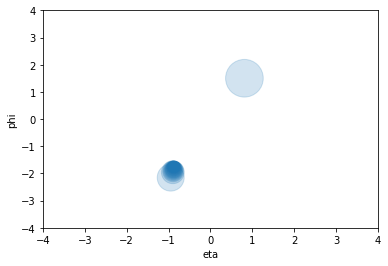

In [40]:
plot_event(recons[6].cpu().detach().numpy(),"GRUsigAE_sigEvent_recons_6")

In [23]:
data_sig[0:4].shape

(4, 40, 3)

In [24]:
recons, kld = model(torch.Tensor(data_sig[0:10]).cuda())

In [25]:
recons_bkg, kld = model(torch.Tensor(data_bkg[0:4]).cuda())

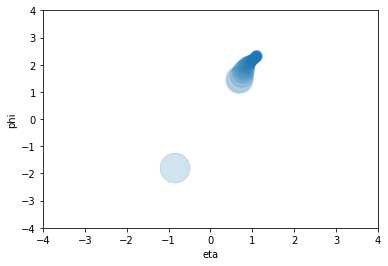

In [29]:
plot_event(recons_bkg[1].cpu().detach().numpy(),"GRUsigAE_bkgEvent_recons_1")

In [ ]:
plot_event(data_bkg[1],"bkgEvent_actual_1")

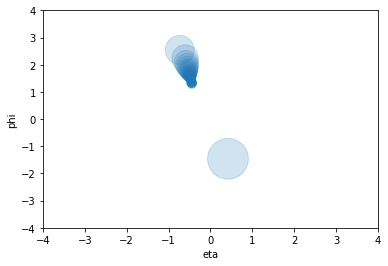

In [35]:
plot_event(recons[3].cpu().detach().numpy(),"GRUsigAE_signalEvt_recons_3")

In [ ]:
plot_event(data_sig[2],"sigEvt_actual_2")

In [ ]:
model_bkg = SentenceVAE(3,10,4).to(device)


In [ ]:
tensor_bkg_train = torch.tensor(data_bkg) 

tensor_bkg_train.shape

bkg_train_iterator = utils.DataLoader(tensor_bkg_train, batch_size=bs, shuffle=True)

In [ ]:
lr = 1e-3
bs = 1000
optimizer = optim.Adam(model_bkg.parameters(), lr=lr)

In [ ]:
loss

In [ ]:
def train_bkg():
    # set the train mode
    model_bkg.train()

    # loss of the epoch
    train_loss = 0

    for i, x in enumerate(bkg_train_iterator):
        # reshape the data into [batch_size, 784]
        x = x.float().cuda()

        # update the gradients to zero
        optimizer.zero_grad()

        # forward pass
        x_sample, kld = model_bkg(x)

        # reconstruction loss
        recon_loss = F.mse_loss(x_sample, x, size_average=False)


        # total loss
        loss = recon_loss + kld
        train_loss += loss.item()

        # backward pass
        loss.backward()

        # update the weights
        optimizer.step()
        
    return train_loss


In [ ]:
best_train_loss = float('inf')

for e in range(1000):

    train_loss = train_bkg()

    train_loss /= len(tensor_bkg_train)
    print(train_loss)
    if best_train_loss > train_loss:
        best_train_loss = train_loss
        patience_counter = 1
        print("Saving model!")
        torch.save(model_bkg.state_dict(),"/data/t3home000/spark/QUASAR/weights/seq2seq_bkg.h5")

    else:
        patience_counter += 1
        print("Not saving model!")

    if patience_counter > 5:
        print("Patience Limit Reached")
        break

# MAKE DATASET

In [ ]:
import torch
from torch_geometric.data import InMemoryDataset, download_url

In [ ]:
class DijetAnomaly(InMemoryDataset):
    

# Make Plotting Scripts, Will later make into a separate module

In [23]:
def plot_event(pfcands, name):

    pt = pfcands[:,0]
    eta = pfcands[:,1]
    phi = pfcands[:,2]
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    ax.scatter(eta,phi,s=pt*10000, alpha=0.2)
    ax.set_xlabel('eta')
    ax.set_ylabel('phi')
    ax.set_xlim([-4,4])
    ax.set_ylim([-4,4])
    fig.savefig(f'figures/{name}.png')

In [ ]:
plot_event(data_sig[4],"event_sig_idx4")

# 40 Body System, 3 features ( pT, eta, Phi) for each object (PF candidate)

In [ ]:
n_objects  = 40 # number of PF candidates(nodes)
object_dim = 3 # features: mass, x coordinate, y coordinate, speed on x-axis, speed on y-axis

n_relations  = n_objects * (n_objects - 1) # number of edges in fully connected graph
relation_dim = 1

effect_dim = 10 #effect's vector size


In [ ]:
n_relations

In [ ]:
data.shape

In [ ]:
def get_batch(data, label, idx, batch_size):
    
    start_idx = idx*batch_size
    end_idx = idx*batch_size+batch_size

    batch_data = data[start_idx: end_idx]
    label_data = label[start_idx: end_idx]
    
    objects = batch_data
    
    
    #receiver_relations, sender_relations - onehot encoding matrices
    #each column indicates the receiver and sender object’s index
    
    receiver_relations = np.zeros((batch_size, n_objects, n_relations), dtype=float);
    sender_relations   = np.zeros((batch_size, n_objects, n_relations), dtype=float);
    
    cnt = 0
    for i in range(n_objects):
        for j in range(n_objects):
            if(i != j):
                receiver_relations[:, i, cnt] = 1.0
                sender_relations[:, j, cnt]   = 1.0
                cnt += 1
    
    #There is no relation info in solar system task, just fill with zeros
    relation_info = np.zeros((batch_size, n_relations, relation_dim))
    target = label_data
    
    objects            = Variable(torch.FloatTensor(objects))
    sender_relations   = Variable(torch.FloatTensor(sender_relations))
    receiver_relations = Variable(torch.FloatTensor(receiver_relations))
    relation_info      = Variable(torch.FloatTensor(relation_info))
    target             = Variable(torch.FloatTensor(target))
                       
    if USE_CUDA:
        objects            = objects.cuda()
        sender_relations   = sender_relations.cuda()
        receiver_relations = receiver_relations.cuda()
        relation_info      = relation_info.cuda()
        target             = target.cuda()
    
    return objects, sender_relations, receiver_relations, relation_info, target


In [ ]:
class RelationalModel(nn.Module):
    def __init__(self, input_size, output_size, hidden_size):
        super(RelationalModel, self).__init__()
        
        self.output_size = output_size
        
        self.layers = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size),
            nn.ReLU()
        )
    
    def forward(self, x):
        '''
        Args:
            x: [batch_size, n_relations, input_size]
        Returns:
            [batch_size, n_relations, output_size]
        '''
        batch_size, n_relations, input_size = x.size()
        x = x.view(-1, input_size)
        x = self.layers(x)
        x = x.view(batch_size, n_relations, self.output_size)
        return x

In [ ]:
class ObjectModel(nn.Module):
    def __init__(self, input_size, hidden_size, D):
        super(ObjectModel, self).__init__()
        
        self.layers = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1), #speedX and speedY
        )
        
    def forward(self, x):
        '''
        Args:
            x: [batch_size, n_objects, input_size]
        Returns:
            [batch_size * n_objects, 2] speedX and speedY
        '''
        input_size = x.size(2)*x.size(1)
        x = x.view(-1, input_size)
        return self.layers(x)


In [ ]:
class InteractionNetwork(nn.Module):
    def __init__(self, n_objects, object_dim, n_relations, relation_dim, effect_dim):
        super(InteractionNetwork, self).__init__()
        
        self.relational_model = RelationalModel(2*object_dim + relation_dim, effect_dim, 150)
        self.object_model     = ObjectModel((object_dim + effect_dim)*n_objects, 100)
    
    def forward(self, objects, sender_relations, receiver_relations, relation_info):
        senders   = sender_relations.permute(0, 2, 1).bmm(objects)
        receivers = receiver_relations.permute(0, 2, 1).bmm(objects)
        effects = self.relational_model(torch.cat([senders, receivers, relation_info], 2))
        effect_receivers = receiver_relations.bmm(effects)
        predicted = self.object_model(torch.cat([objects, effect_receivers], 2))
        return predicted

In [ ]:
USE_CUDA = True

In [ ]:
interaction_network = InteractionNetwork(n_objects, object_dim, n_relations, relation_dim, effect_dim)

if USE_CUDA:
    interaction_network = interaction_network.cuda()
    
optimizer = optim.Adam(interaction_network.parameters())
criterion = nn.BCEWithLogitsLoss()



In [ ]:
n_epoch = 100
batch_size=1000
batches_per_epoch = int(len(data)/batch_size)

losses = []
for epoch in range(n_epoch):
    for idx in range(batches_per_epoch):
        print((idx/batches_per_epoch)*100,"percent")
        objects, sender_relations, receiver_relations, relation_info, target = get_batch(data, label, idx, batch_size)
        predicted = interaction_network(objects, sender_relations, receiver_relations, relation_info)
        loss = criterion(predicted.flatten(), target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.data.cpu().numpy())
        
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('Epoch %s RMS Error %s' % (epoch, np.sqrt(np.mean(losses[-100:]))))
    plt.plot(losses)
    plt.show()